# BindsNet Neuron (Node) Models

## 1. Table of Contents
1. Table of Contents
2. Overview
3. Import Statements
4. Network Structure
5. Neuron Models
    1. IFNodes
    2. LIFNodes
    3. CurrentLIFNodes
    4. AdaptiveLIFNodes
    5. SRM0Nodes

## 2. Overview
Detailed documentation of the node creation process has been specified [here](https://bindsnet-docs.readthedocs.io/guide/guide_part_i.html#creating-a-network). This document will go into more specific examples of configuring a spiking neural network in BindsNET.

## 3. Import Statements

In [56]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from bindsnet.encoding import *
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, IFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor

from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_input, plot_weights

## 4. Network Structure

`Network` object is responsible for the coordination of simulation of all its constituent components: neurons, synapses, learning rules, etc.

The `dt` argument specifies the simulation time step in milliseconds

In [57]:
network = Network()

Create a layer of 4 LIF neurons with shape (2, 2).
* one of either `n` or `shape` usually required
* `thresh` argument specifies threshold voltage for the layer
* `rest` argument specifies resting voltage for the layer
* `traces` keeps track of "spike traces"
* `tc_decay` argument specifies leakage

Classes of `Nodes`:
* Inputs
* McCullochPitts
* IFNodes
* LIFNodes
* CurrentLIFNodes
* AdaptiveLIFNodes
* DiehlAndCookNodes
* IzhikevichNodes
* SRM0Nodes

In [58]:
network = Network()

lif_layer = LIFNodes(n=2)

`Nodes` (layer) objects get added to the `Network` object

In [59]:
network = Network()

lif_layer = LIFNodes(n=2)

network.add_layer(
    layer=lif_layer, name="LIF population"
)

`AbstractConnection` objects connect the layers
* `source` and `target` layers must be specified
* `w` argument specifies the weight of the synapse
* `b` argument specifies the bias of the synapse
* `wmin` and `wmax` arguments specify the min and max allowable weight values
* `norm` argument is a floating point value used to normalize the weights

Recurrent connections can be formed by connecting a layer to itself

Classes of `AbstractConnection`:
* Connection
* Conv2dConnection
* MaxPool2dConnection
* LocalConnection
* MeanFieldConnection
* SparseConnection

In [60]:
# Create two populations of neurons, one to act as the "source"
# population, and the other, the "target population".
input_layer = Input(n=4)
lif_layer = LIFNodes(n=2)

# Connect the two layers.
connection = Connection(
    source=input_layer, target=lif_layer
)

# add the two layers to the network
network.add_layer(
    layer=input_layer, name="Input Layer"
)
network.add_layer(
    layer=lif_layer, name="LIF Layer"
)

# weights specified in connection
network.add_connection(
    connection=connection, source="Input Layer", target="LIF Layer"
)

`Montior` objects can record tensor valued variables (state variables from `Nodes` and `AbstractConnections` objects) over time

In [61]:
network = Network()

input_layer = Input(n=4)
lif_layer = LIFNodes(n=2)

# simulation duration in milliseconds
time = 100

connection = Connection(
    source=input_layer, target=lif_layer
)

# Create a monitor.
lif_layer_monitor = Monitor(
    obj=lif_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

# add layers to network
network.add_layer(
    layer=input_layer, name="Input Layer"
)
network.add_layer(
    layer=lif_layer, name="LIF Layer"
)

# add connection to network
network.add_connection(
    connection=connection, source="Input Layer", target="LIF Layer"
)

# add monitor to the network
network.add_monitor(monitor=lif_layer_monitor, name="LIF Layer")

`NetworkMonitor` can be used to record from several monitors at once

In [62]:
'''
network_monitor = NetworkMonitor(
    network: Network,
    layers: Optional[Iterable[str]],
    connections: Optional[Iterable[Tuple[str, str]]],
    state_vars: Optional[Iterable[str]],
    time: Optional[int],
)
'''

'\nnetwork_monitor = NetworkMonitor(\n    network: Network,\n    layers: Optional[Iterable[str]],\n    connections: Optional[Iterable[Tuple[str, str]]],\n    state_vars: Optional[Iterable[str]],\n    time: Optional[int],\n)\n'

`Network.run` used to simulate the network on provided input data

tensor([[1., 2.],
        [1., 3.],
        [2., 2.],
        [1., 0.]])


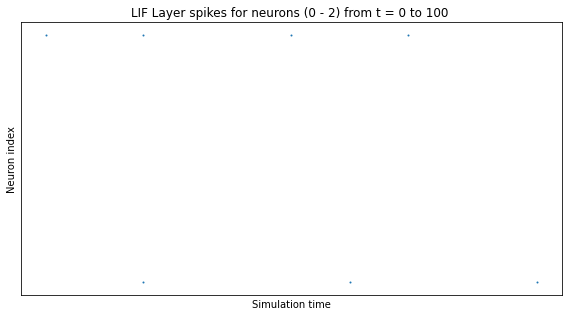

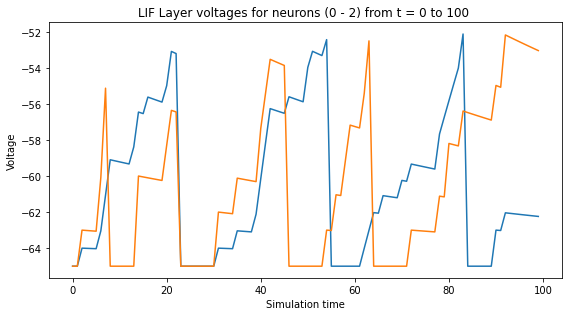

In [63]:
# initialize network
network = Network()

# set number of neurons
input_neurons = 4
lif_neurons = 2

# simulation time
time = 100
dt = 1

# configure weights for the synapses between the input layer and LIF layer
w = torch.round(torch.abs(2 * torch.randn(input_neurons, lif_neurons)))

# initialize input and LIF layers
input_layer = Input(n=input_neurons)
lif_layer = LIFNodes(n=lif_neurons)

# connection between the input layer and the LIF layer
connection = Connection(
    source=input_layer, target=lif_layer,w=w
)

# create a monitor
lif_layer_monitor = Monitor(
    obj=lif_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

# add layers to network
network.add_layer(
    layer=input_layer, name="Input Layer"
)
network.add_layer(
    layer=lif_layer, name="LIF Layer"
)

# add connection to network
network.add_connection(
    connection=connection, source="Input Layer", target="LIF Layer"
)

# add monitor to the network
network.add_monitor(monitor=lif_layer_monitor, name="LIF Layer")

# create input spike data, where each spike is distributed according to Bernoulli(0.1)
input_data = torch.bernoulli(0.1 * torch.ones(time, input_layer.n)).byte()
encoded_image = input_data
inputs = {"Input Layer": input_data}

# simulate network on input data
network.run(inputs=inputs, time=time)

# retrieve and plot simulation spike, voltage data from monitors
spikes = {"LIF Layer": lif_layer_monitor.get("s")}
voltages = {"LIF Layer": lif_layer_monitor.get("v")}

# plot spikes and voltages of the LIF layer
# TODO: plot axes
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
# plot_weights(w)

# plot image
# TODO: use a standard input image and encode it
# e_img = encoded_image.view(int(time / dt), 1, 1, input_layer.n, 1)
# inpt = e_img.view(int(time / dt), input_layer.n).sum(0).view(input_layer.n, 1)
# plot_input(input_data,inpt)

plt.show()

## 5. Neuron Models

## 5a. Leaky Integrate-and-Fire Model